## Imports

In [199]:
import unidecode
import string
import random
import re
import time
import torch
import torch.nn as nn
import numpy as np 
import os 

from IPython.core.debugger import set_trace
from torch.autograd import Variable
from torchviz import make_dot
from torch.utils.data import TensorDataset, DataLoader
from utils import load_gfp_data, get_all_amino_acids, get_wild_type_amino_acid_sequence, count_substring_mismatch

## Model

In [268]:
# https://github.com/spro/char-rnn.pytorch/blob/master/model.py
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="lstm", n_layers=1):
        super(RNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # input is of shape (batch_size, 1) where each input[x, 0] is the word index
        # char RNN so we generate one character at a time. 
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden
    
    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
    
class GenerativeRNN(): 
    
    def __init__(self, args):     
        """
        Initializes the RNN to be a generative char RNN
        Parameters
        ----------
        args : dictionary
            defines the hyper-parameters of the neural network
        args.name : string 
            defines the name of the neural network
        args.description: string
            describes the architecture of the neural network
        args.input : int 
            defines the input/vocabulary size
        args.output : int
            the number of output layers in the final layer of the neural network
        args.layers : int
            specifies the number of stacked layers we want in the LSTM
        args.hidden_size : int
            the size of the hidden layer
        args.learning_rate : float
            sets the learning rate
        args.epochs : int 
            sets the epoch size 
        """
        self.name = args["name"]
        self.description = args["description"]
        self.input = args["input"]
        self.output = args["output"]
        self.layers = args["layers"]
        self.hidden_size = args["hidden_size"]
        self.learning_rate = args["learning_rate"]
        self.epochs = args["epochs"]
        self.model = RNN(self.input, self.hidden_size, self.output, "lstm", self.layers)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.loss_history = []
        

    def fit(self, dataloader, verbose=True, logger=None, save_model=True):
        # amino acid dataset specific checks
        wild_type = get_wild_type_amino_acid_sequence()
        three_mutation = "".join([int_to_character[np.random.randint(0, num_characters)] if i % 3 == 1 else wild_type[i] for i in range(10)])
        ten_mutation = "".join([int_to_character[np.random.randint(0, num_characters)] for i in range(10)])
        print(wild_type[0:10], three_mutation, ten_mutation)
        
        if not os.path.isdir("./models/{0}".format(self.name)):
            os.mkdir("./models/{0}".format(self.name))
        
        start_time = time.time()
        self.loss_history = []
        for epoch in range(1, n_epochs + 1):
            total_loss = []
            for i, (input, target) in enumerate(dataloader):
                batch_size, seq_length = input.shape[0], input.shape[1]
                hidden = self.model.init_hidden(batch_size)
                self.model.zero_grad()
                loss = 0
                for c in range(seq_length):
                    output, hidden = self.model(input[:, c], hidden)
                    loss += self.criterion(output.view(batch_size, -1), target[:, c])
                
                loss.backward()
                self.optimizer.step()
                total_loss.append(loss.data[0] / seq_length)
            
            self.loss_history.append(np.mean(total_loss))
            generated_sequence = self.sample(prime_str = "S", predict_len = len(wild_type) - 1)
            mismatches = count_substring_mismatch(wild_type, generated_sequence)
            wild_prob, mutation_three_prob, mutation_ten_prob = self.predict_log_prob(wild_type[1:10]), self.predict_log_prob(three_mutation[1:10]), self.predict_log_prob(ten_mutation[1:10])
            
            if verbose: 
                print("epoch {0}. loss: {1:.2f}. time: {2:.2f} seconds.".format(epoch, self.loss_history[-1], time.time() - start_time), file = logger)
                print("generated sequence: {0}\n{1} mismatches from the wild type".format(generated_sequence, mismatches), file = logger) 
                print("wild type log prob: {0}. 3 mutations log prob: {1}. 10 mutations log prob: {2}.\n" \
                      .format(wild_prob, mutation_three_prob, mutation_ten_prob), file = logger)
            if save_model:
                self.save_model(epoch, total_loss)        
        
        if logger:        
            logger.close()

    def predict_log_prob(self, sequence, prime_str = "S"):
        hidden = self.model.init_hidden(1) 
        prime_input = string_to_tensor(prime_str)
        for p in range(len(prime_str) - 1):
            _, hidden = self.model(prime_input[p], hidden)
        input = prime_input[-1]

        log_prob = 0
        for char in sequence:
            output, hidden = self.model(input.view(1, -1), hidden)
            softmax = nn.Softmax(dim = 1)
            probs = softmax(output).view(-1)
            i = character_to_int[char]
            log_prob += np.log(probs[i].item())
        return log_prob

    def sample(self, predict_len, prime_str = 'S', temperature = 1):
        hidden = self.model.init_hidden(1)
        prime_input = string_to_tensor(prime_str)
        predicted = prime_str

        # Use priming string to "build up" hidden state
        for p in range(len(prime_str) - 1):
            output, hidden = self.model(prime_input[p], hidden)
        input = prime_input[-1]

        for p in range(predict_len):
            output, hidden = self.model(input.view(1, -1), hidden)

            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0].item()

            # Add predicted character to string and use as next input
            predicted_char = int_to_character[top_i]
            predicted += predicted_char
            input = string_to_tensor(predicted_char)

        return predicted

            
    def load_model(self, model_path):
        checkpoint = torch.load("./models/{0}/{1}".format(self.name, model_path))
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    def save_model(self, epoch=None, loss=None): 
        torch.save({
                    'epoch': epoch,
                    'loss': loss,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict()
                }, "./models/{0}/checkpoint_{1}.pt".format(self.name, epoch))

    
    def show_model(self): 
        print(self.model)
    
    def plot_model(self, save_dir, verbose=True): 
        hidden = self.model.init_hidden(1)
        out, _ = self.model(string_to_tensor("S"), hidden)
        graph = make_dot(out)
        if save_dir is not None:
            graph.format = "png"
            graph.render(save_dir) 
        if verbose:
            graph.view()
            
    def plot_history(self, save_fig_dir): 
        plt.figure()
        plt.title("Training Loss Curve")
        plt.plot(self.loss_history)
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.xticks(range(self.epochs))
        if save_fig_dir:
            plt.savefig(save_fig_dir)
        plt.show()
        
            
    

# Loading Data

In [274]:
"""
1. print to file the epoch the time it took and the loss, print out a generated sample and the mismatches (DONE)
2. plot history (DONE)
3. save model every epoch, load model at end, plot model architecture (DONE)
4. tensorboard going (DONE)
5. code it into class (DONE)
6. debug (DONE)
7. Write tests 10 min (DONE)
""" 

'\n1. print to file the epoch the time it took and the loss, print out a generated sample and the mismatches (DONE)\n2. plot history (DONE)\n3. save model every epoch, load model at end, plot model architecture (DONE)\n4. tensorboard going (DONE)\n5. code it into class (DONE)\n6. Write tests 10 min (DONE)\n7. debug (DONE)\n'

In [276]:
all_characters = get_all_amino_acids()
num_characters = len(all_characters)
character_to_int = dict(zip(all_characters, range(num_characters)))
int_to_character = dict(zip(range(num_characters), all_characters))

def string_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for i, c in enumerate(string): 
        tensor[i] = character_to_int[c]
    return tensor

def string_to_numpy(string):
    arr = np.zeros(len(string))
    for i, c in enumerate(string): 
        arr[i] = character_to_int[c]
    return arr
    
def get_dataloader(X_train, length, n = 100, batch_size = 1, shuffle=True, random=True):
    if not random: 
        data = X_train[0:n]
    else: 
        indexes = np.random.choice(len(X_train), n)
        data = X_train[indexes]        
    dataset = np.array([string_to_numpy(x[0:length]) for x in data])
    input = torch.from_numpy(dataset[:, :-1]).long()
    output = torch.from_numpy(dataset[:, 1:]).long()
    tensor_dataset = TensorDataset(input, output)
    return DataLoader(tensor_dataset, batch_size = batch_size, shuffle = shuffle)

def get_medium_args():
    return {
        "name" : "rnn_test_sample",
        "description" : "layers 2, hidden size 200, lr 0.005, epochs 10",
        "input" : num_characters,
        "output" : num_characters,
        "layers" : 2, 
        "hidden_size" : 200,
        "learning_rate" : 0.005,
        "epochs" : 10 
    }


wild_type = get_wild_type_amino_acid_sequence()
seq_length = len(wild_type)
batch_size = 10
X_train, X_test, y_train, y_test = load_gfp_data("./data/gfp_amino_acid_")
dataloader = get_dataloader(X_train, length=seq_length, n=99, batch_size=batch_size, shuffle=True, random=True)
args = get_medium_args()


## Experiments

SKGEELFTGV SIGE*LFGGV VRRHYEQTQI


/Users/chuck/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:98: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


RNN(
  (encoder): Embedding(21, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (decoder): Linear(in_features=200, out_features=21, bias=True)
)


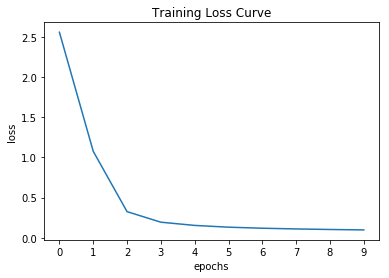

temperature: 0.2. generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK with 1 mismatches from the wild type.
temperature: 0.8. generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHFDKNFKSRERVEDFKFVPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDGELYKTAAKIGDVQLEDFKNGILVNKGIELKGIDFKEDGNILGHKLVEFVTAGITHGMVELEFTGTGVVPILVELDGDVNRILGHKLEYNYN with 145 mismatches from the wild type.
temperature: 1.0. generated sequence: SMKEGETLFVTGIGDGPVLLPDNHYLSTQSALSKTEGDATVLGIDDGHKLNYNSHMVQLADHMVEKFSGVIELGDDGVNRIELHKFEGDTLYKNRHIDFKSGDPNETRHKEFKDNYNSHNYVLADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSAILKDDNKIFKEGDTLVNRIELKGIDFKEDGNIHLYKNIGHKLYNSHNVYIMADKQKNGIKV with 217 mismatches from the wild type.
temperature: 1.2. generated sequence: SKGEELFGVTLSYGVQ

In [282]:
rnn = GenerativeRNN(args)
logger = open("./logs/{0}.txt".format(args["name"]), "w")
rnn.fit(dataloader=dataloader, logger=logger)
rnn.show_model()
rnn.plot_history("./logs/{0}_training_history".format(args["name"]))
rnn.plot_model("./logs/{0}_model_architecture".format(args["name"]))
temperature_lst = [0.2, 0.8, 1.0, 1.2, 1.8]
for temperature in temperature_lst: 
    generated_sequence = sample("S", seq_length - 1, temperature=temperature)
    mismatches = count_substring_mismatch(wild_type, generated_sequence)
    print("temperature: {0}. generated sequence: {1} with {2} mismatches from the wild type.".format(temperature, generated_sequence, mismatches)) 
    

In [285]:
def enumerate_all_sequences(model, string, base = "S", depth = 3): 
    if depth == 0: 
        return np.e ** model.predict_log_prob(string, base)
    total = 0
    for c in all_characters: 
        total += enumerate_all_sequences(model, string + c, base, depth - 1)
    return total

for depth in range(1, 4):
    for base in "QRST":
        np.testing.assert_almost_equal(1, enumerate_all_sequences(rnn, "", base, depth))


In [284]:
epoch = 3
load_rnn = GenerativeRNN(args)
load_rnn.load_model("./checkpoint_{0}.pt".format(epoch))
total_loss = []
for i, (input, target) in enumerate(dataloader):
    batch_size, seq_length = input.shape[0], input.shape[1]
    hidden = load_rnn.model.init_hidden(batch_size)
    loss = 0
    for c in range(seq_length):
        output, hidden = load_rnn.model(input[:, c], hidden)
        loss += load_rnn.criterion(output.view(batch_size, -1), target[:, c])
    total_loss.append(loss.data[0] / seq_length) 
print(total_loss)
print(torch.load("./models/rnn_test_sample/checkpoint_{0}.pt".format(epoch))["loss"])

/Users/chuck/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


[tensor(0.2853), tensor(0.1678), tensor(0.1911), tensor(0.1967), tensor(0.1559), tensor(0.2365), tensor(0.2600), tensor(0.2189), tensor(0.1826), tensor(0.1993)]
[tensor(0.5044), tensor(0.4353), tensor(0.4265), tensor(0.3414), tensor(0.2914), tensor(0.2785), tensor(0.2048), tensor(0.2876), tensor(0.2327), tensor(0.2484)]
